In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-07-04 23:55:14.567760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:55:14.567974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:55:14.568107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:55:14.568313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:55:14.568447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12312979390862607441
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5979439104
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3429206528894878798
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

702 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [5]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
# h5 = h5py.File('./data/All_cases_100x100_per500_zoom_06222022.hdf5', mode='r')
h5 = h5py.File('./data/test_multiChannels_07042022.hdf5', mode='r')
# h5 = h5py.File('./data/All_cases_100x100_per500_zoom.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])
print(train_index)
print(val_index)
print(dataset.shape)

[ 1  2  3  4  5  7  8 11 12 14 15 16 18 20 21 22 23 24 25 26 27 28 29 30
 32 34 35 36 37 38 39 40 41 43 44 45 46 48 49 50 52 53 54 55 56 57 58 59
 61 62 64 66 70 71 72 73 74 75 77 78 79 82 83 84 85 86 88 90 91]
[ 0  6  9 10 13 17 19 31 33 42 47 51 60 63 65 67 68 69 76 80 81 87 89]
(92, 35, 100, 100, 5)


In [6]:
# this part is a bit slow
train_dataset = dataset[train_index,...]
val_dataset = dataset[val_index,...]

In [7]:
train_dataset.shape

(69, 35, 100, 100, 5)

In [138]:
# from tqdm import tqdm

# def create_shifted_frames_3to1(dataset):
#     numFrames = 3

#     for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
#         for j in range(dataset.shape[1]-numFrames):
#             currentFrame = np.expand_dims(np.expand_dims(dataset[i,j+numFrames,...],axis=0),axis=0)
#             pastFrames = np.expand_dims(dataset[i,j:(j+numFrames),...],axis=0)
#             try:
#                 x = np.append(x, pastFrames, axis=0)
#                 y = np.append(y, currentFrame, axis=0)
#             except:
#                 x = pastFrames
#                 y = currentFrame
                
#     return x,y

# x_train, y_train = create_shifted_frames_3to1(train_dataset)
# print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
# x_val, y_val = create_shifted_frames_3to1(val_dataset)
# print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

In [139]:
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
# plt.figure(figsize=(16, 4), dpi=60)
# plt.subplot(1,4,1)
# plt.imshow(x_train[data_choice,0,:,:,0])
# plt.colorbar()
# plt.subplot(1,4,2)
# plt.imshow(x_train[data_choice,1,:,:,0])
# plt.colorbar()
# plt.subplot(1,4,3)
# plt.imshow(x_train[data_choice,2,:,:,0])
# plt.colorbar()
# plt.subplot(1,4,4)
# plt.imshow(y_train[data_choice,0,:,:,0])
# plt.colorbar()

In [140]:
from tqdm import tqdm

def create_shifted_frames_3to1(dataset):
    numFrames = 5

    for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
        for j in range(dataset.shape[1]-numFrames):
            currentFrame = np.expand_dims(np.expand_dims(np.expand_dims(dataset[i,j+numFrames,:,:,0],axis=0),axis=0),axis=4)
            pastFrames = np.expand_dims(np.expand_dims(dataset[i,j:(j+numFrames),:,:,0],axis=0),axis=4)
            try:
                x = np.append(x, pastFrames, axis=0)
                y = np.append(y, currentFrame, axis=0)
            except:
                x = pastFrames
                y = currentFrame
                
    return x,y

x_train, y_train = create_shifted_frames_3to1(train_dataset)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
x_val, y_val = create_shifted_frames_3to1(val_dataset)
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Running ...: 100%|██████████| 69/69 [02:02<00:00,  1.78s/it]


Training Dataset Shapes: (2070, 5, 100, 100, 1), (2070, 1, 100, 100, 1)


Running ...: 100%|██████████| 23/23 [00:13<00:00,  1.75it/s]

Validation Dataset Shapes: (690, 5, 100, 100, 1), (690, 1, 100, 100, 1)


In [8]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (69, 34, 100, 100, 5), (69, 34, 100, 100, 5)
Validation Dataset Shapes: (23, 34, 100, 100, 5), (23, 34, 100, 100, 5)


In [142]:
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
# plt.figure(figsize=(16, 16), dpi=60)
# plt.subplot(4,4,1)
# plt.imshow(x_train[data_choice,0,:,:,0])
# plt.colorbar()
# plt.subplot(4,4,2)
# plt.imshow(x_train[data_choice,1,:,:,0])
# plt.colorbar()
# plt.subplot(4,4,3)
# plt.imshow(x_train[data_choice,2,:,:,0])
# plt.colorbar()
# plt.subplot(4,4,4)
# plt.imshow(y_train[data_choice,0,:,:,0])
# plt.colorbar()

# plt.subplot(4,4,5)
# plt.imshow(x_train[data_choice,0,:,:,1])
# plt.colorbar()
# plt.subplot(4,4,6)
# plt.imshow(x_train[data_choice,1,:,:,1])
# plt.colorbar()
# plt.subplot(4,4,7)
# plt.imshow(x_train[data_choice,2,:,:,1])
# plt.colorbar()
# plt.subplot(4,4,8)
# plt.imshow(y_train[data_choice,0,:,:,1])
# plt.colorbar()

# plt.subplot(4,4,9)
# plt.imshow(x_train[data_choice,0,:,:,2])
# plt.colorbar()
# plt.subplot(4,4,10)
# plt.imshow(x_train[data_choice,1,:,:,2])
# plt.colorbar()
# plt.subplot(4,4,11)
# plt.imshow(x_train[data_choice,2,:,:,2])
# plt.colorbar()
# plt.subplot(4,4,12)
# plt.imshow(y_train[data_choice,0,:,:,2])
# plt.colorbar()

# plt.subplot(4,4,13)
# plt.imshow(x_train[data_choice,0,:,:,3])
# plt.colorbar()
# plt.subplot(4,4,14)
# plt.imshow(x_train[data_choice,1,:,:,3])
# plt.colorbar()
# plt.subplot(4,4,15)
# plt.imshow(x_train[data_choice,2,:,:,3])
# plt.colorbar()
# plt.subplot(4,4,16)
# plt.imshow(y_train[data_choice,0,:,:,3])
# plt.colorbar()


(69, 34, 100, 100, 5)
68


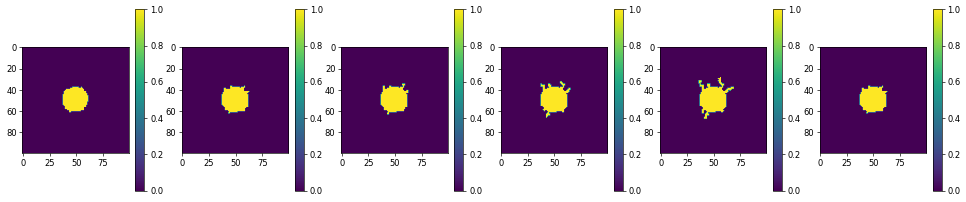

In [14]:
print(x_train.shape)
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
print(data_choice)
plt.figure(figsize=(20, 4), dpi=60)
plt.subplot(1,6,1)
plt.imshow(x_train[data_choice,0,:,:,0])
plt.colorbar()
plt.subplot(1,6,2)
plt.imshow(x_train[data_choice,1,:,:,0])
plt.colorbar()
plt.subplot(1,6,3)
plt.imshow(x_train[data_choice,2,:,:,0])
plt.colorbar()
plt.subplot(1,6,4)
plt.imshow(x_train[data_choice,3,:,:,0])
plt.colorbar()
plt.subplot(1,6,5)
plt.imshow(x_train[data_choice,4,:,:,0])
plt.colorbar()
plt.subplot(1,6,6)
plt.imshow(y_train[data_choice,0,:,:,0])
plt.colorbar()

In [48]:
from tensorflow.keras import layers

inp = layers.Input(shape=(None, *x_train.shape[2:]))
# inp = layers.Input(shape=(x_train.shape[1:]))

drop_rate = 0.1
x0 = layers.TimeDistributed(layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(inp)
# x0 = layers.Dropout(drop_rate)(x0)
x1 = layers.TimeDistributed(layers.Conv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x0)
# x1 = layers.Dropout(drop_rate)(x1)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    recurrent_dropout=drop_rate,
)(x1)
x3 = layers.Concatenate(axis=4)([x1,x2])
# x3 = x1+x2
x4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(x1)
# ))(x3)
# x4 = layers.Dropout(drop_rate)(x4)
x5 = layers.Concatenate(axis=4)([x0,x4])
# x5 = x0+x4
x6 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=5,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    # activation="sigmoid",
    activation="relu",
))(x4)
# ))(x5)
x6 = layers.Dropout(drop_rate)(x6)

In [49]:
# def sum_filter_python(phi):
#     phi = phi.numpy()
#     Nx = phi.shape[0]
#     Ny = phi.shape[1]
#     phi = np.round(phi)

#     phi_sum = np.zeros([Nx,Ny])
#     for i in range(5,Nx-4):
#         for k in range(5,Ny-4):
#             for j in range(k-4,k+4+1):
#                 phi_sum[i,k] = phi_sum[i,k] + int(phi[i,k]==phi[i-4,j])*phi[i-4,j] + int(phi[i,k]==phi[i-3,j])*phi[i-3,j] + int(phi[i,k]==phi[i-2,j])*phi[i-2,j] + int(phi[i,k]==phi[i-1,j])*phi[i-1,j] + int(phi[i,k]==phi[i-0,j])*phi[i,j] + int(phi[i,k]==phi[i+1,j])*phi[i+1,j] + int(phi[i,k]==phi[i+2,j])*phi[i+2,j] + int(phi[i,k]==phi[i+3,j])*phi[i+3,j] + int(phi[i,k]==phi[i+4,j])*phi[i+4,j]

#     phi_sum = np.divide(phi,phi_sum)
#     phi_sum[np.isnan(phi_sum)] = 0
#     phi_sum_max = np.amax(np.amax(phi_sum))
#     phi_sum = np.divide(phi_sum,phi_sum_max)

#     phi_sum_temp = phi_sum
#     cutoff = np.percentile(np.reshape(phi_sum_temp,[Nx*Ny,1]),99.97)
#     phi_sum[phi_sum<cutoff] = 0
#     phi_sum[phi_sum!=1] = 0  
#     out = tf.Variable(tf.zeros([Nx,Ny],tf.float64))
#     out.assign(phi_sum)
#     return out

# def highlightZone(tip):
#     [Max_y,Max_x] = np.where(tip==1)
#     size_Max = len(Max_x)
#     Nx, Ny = phi_plot.shape
#     tips = np.zeros([Nx,Ny])
#     temp = np.zeros([Nx,Ny])
#     for l in range(0,size_Max):
#         max_x = Max_x[l]
#         max_y = Max_y[l]
#         for i in range(max_y-2,max_y+2):
#             for j in range(max_x-2,max_x+2):
#                     temp[i,j] = 1
#         tips = tips+temp

#     tips[np.abs(tips)>0] = 1
#     return tips

In [50]:
# def sum_filter_python(phi):
#     [Nx,Ny] = tf.shape(phi)
#     phi = tf.math.round(phi)
#     phi_sum = tf.Variable(tf.zeros([Nx,Ny],tf.float32))
#     for i in range(5,Nx-4):
#         for k in range(5,Ny-4):
#             for j in range(k-4,k+4+1):
#                 phi_sum[i,k].assign(tf.math.add(tf.cast(phi[i,k],tf.float32),tf.multiply(tf.cast(phi[i,k]==phi[i-4,j],tf.float32),phi[i-4,j])))

#     return phi_sum

In [51]:
# import scipy.io
# cm = scipy.io.loadmat('cm_20.mat')["cm"][0]
# cm["NuNv"][0] = cm["NuNv"][0].todense()
# cm["N1uNv"][0] = cm["N1uNv"][0].todense()
# cm["NuN1v"][0] = cm["NuN1v"][0].todense()
# cm["N2uNv"][0] = cm["N2uNv"][0].todense()
# cm["NuN2v"][0] = cm["NuN2v"][0].todense()
# cm["N2uN2v"][0] = cm["N2uN2v"][0].todense()

In [52]:
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# drop_rate = 0.1
# x0 = layers.TimeDistributed(layers.Conv2D(
#     filters=32,
#     kernel_size=(5, 5),
#     strides = (2, 2),
#     padding="valid",
#     activation="relu",
# ))(inp)
# x1 = layers.TimeDistributed(layers.Conv2DTranspose(
#     filters=1,
#     kernel_size=(6, 6),
#     strides = (2, 2),
#     padding="valid",
#     activation="sigmoid",
# ))(x0)

In [53]:
# from tensorflow.keras import backend as K

# def PINN_loss_1(cm, inp):
#     def loss(y_true, y_pred):
#         NuNv = cm["NuNv"][0]
#         N1uNv = cm["N1uNv"][0]
#         NuN1v = cm["NuN1v"][0]
#         N2uNv = cm["N2uNv"][0]
#         NuN2v = cm["NuN2v"][0]
#         N2uN2v = cm["N2uN2v"][0]

#         # need to figure the correct dt, and T_pre
#         dt = 1
#         T_pre = tf.cast(K.reshape(y_pred[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64)
#         xtheta = tf.cast(K.reshape(y_pred[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64)
        
#         phiK = tf.linalg.solve(NuNv,tf.cast(K.reshape(y_pred[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64))
#         # error when calling tf.linalg.solve the second time, suspecting memory related issue
#         phi = tf.linalg.solve(NuNv, tf.cast(K.reshape(inp[0,0,:,:,0], [y_pred.shape[2]*y_pred.shape[3],1]), dtype=tf.float64))
#         # phi = phiK

#         NNpk = tf.linalg.matmul(NuNv,phiK)
#         NNp = tf.linalg.matmul(NuNv,phi)

#         # Temperature calculation
#         T = (3*tf.linalg.matmul(N2uN2v,T_pre)+4*(NNpk - NNp)/dt + T_pre)*dt

#         # Energy calculation
#         E = 0.2865*tf.math.atan(10*(1-T))

#         # Tubulin

#         # a, aap
#         N1Np = tf.linalg.matmul(N1uNv,phi)
#         NN1p = tf.linalg.matmul(NuN1v,phi)
#         atheta = tf.math.atan2(NN1p,N1Np)
#         epsilon = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-xtheta)))
#         epsilon_deriv = -0.04*(6*0.1*tf.math.sin(6*(atheta-xtheta)))
#         aap = tf.math.multiply(epsilon,epsilon_deriv)

#         # phi
#         # (phiK-phi)/dt = 60*()
#         residual = tf.math.add(tf.math.add(E,T),epsilon_deriv)

#         print(phiK.shape)
#         print(phiK.dtype)        
        
#         inn = tf.keras.backend.cast(inp[0,0,:,:,0],dtype='float64')
#         print(inn.shape)
#         print(inn.dtype)
#         residual = inn

#         return residual
#     return loss

In [54]:
from tensorflow.keras import backend as K

def get_deriv(input):
    N1N_input, NN1_input = tf.image.image_gradients(input)
    N2N_input, _ = tf.image.image_gradients(N1N_input)
    _, NN2_input = tf.image.image_gradients(NN1_input)
    LAP_input = tf.math.add(N2N_input,NN2_input)
    return N1N_input, NN1_input, N2N_input, NN2_input, LAP_input

def PINN_loss():
    def loss(y_true, y_pred):
        # need to figure the correct dt, and T_pre
        dt = 0.01*100
        # variables should be from inp
        tempr_pre = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        theta = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        NN_p = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        tub_pre = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)

        NN_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)

        # N1N_pK, NN1_pK, N2N_pK, N2N_pK, LAP_pK = get_deriv(NN_pK)
        N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
        N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
        _, _, _, _, LAP_tp = get_deriv(tempr_pre)
        N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_pre)

        # Temperature calculation
        tempr = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_pre

        # Tubulin Equation
        diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
        alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_pre) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_pre) + tf.math.multiply(NN_p,NN1_tb))
        beta_tb = 0.001*tf.math.multiply(NN_p,tub_pre)
        src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
        tub_K = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_pre

        # Energy calculation
        E = 0.2865*tf.math.atan(10*tf.math.multiply(5*tub_K-0.1,1-tempr))

        # phase field equation residual
        atheta = tf.math.atan2(NN1_p,N1N_p)
        a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
        ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
        aap = tf.math.multiply(a,ap)
        a2 = tf.math.square(a)
        a2Lap = tf.math.multiply(a2,LAP_p)
        N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
        _, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
        mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
        dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + E + 6*0.007*mag_theta)
        phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt
        
        residual = tf.math.reduce_mean(phi_residual)
        y_MSE = tf.math.reduce_mean(tf.square(tf.math.subtract(y_true[0,0,:,:,0], y_pred[0,0,:,:,0])))
        print(y_MSE)
        
        return y_MSE
    return loss

In [55]:
# import scipy.io
# # inn = scipy.io.loadmat('phi_plot.mat')['phi_plot']
# inn_true = x_train[0,20,:,:,0]
# inn_pred = y_train[0,20,:,:,0]
# plt.subplot(1,2,1)
# plt.imshow(inn_true)
# plt.subplot(1,2,2)
# plt.imshow(inn_pred)

# inn = tf.expand_dims(tf.expand_dims(inn_true, axis=0), axis=3)
# N1Np, NN1p = tf.image.image_gradients(inn)
# N2Np, _ = tf.image.image_gradients(N1Np)
# _, NN2p = tf.image.image_gradients(NN1p)
# lap = tf.math.add(N2Np,NN2p)
# plt.figure(figsize=(16, 4), dpi=60)
# plt.subplot(1,5,1)
# plt.imshow(N1Np[0,:,:,0])
# plt.colorbar()
# plt.subplot(1,5,2)
# plt.imshow(NN1p[0,:,:,0])
# plt.colorbar()
# plt.subplot(1,5,3)
# plt.imshow(N2Np[0,:,:,0])
# plt.colorbar()
# plt.subplot(1,5,4)
# plt.imshow(NN2p[0,:,:,0])
# plt.colorbar()
# plt.subplot(1,5,5)
# plt.imshow(lap[0,:,:,0])
# plt.colorbar()

In [56]:
# dt = 1
# tempr_pre = tf.cast(tf.expand_dims(tf.expand_dims(inn_pred,axis=0),axis=3), dtype=tf.float64)
# theta = tf.cast(tf.expand_dims(tf.expand_dims(inn_pred,axis=0),axis=3), dtype=tf.float64)
# NN_p = tf.cast(tf.expand_dims(tf.expand_dims(inn_pred,axis=0),axis=3), dtype=tf.float64)
# tub_pre = tf.cast(tf.expand_dims(tf.expand_dims(inn_pred,axis=0),axis=3), dtype=tf.float64)

# NN_pK = tf.cast(tf.expand_dims(tf.expand_dims(inn_pred,axis=0),axis=3), dtype=tf.float64)

In [57]:
model = keras.models.Model(inp, x6)
model.compile(
    loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    # loss=PINN_loss(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-6))
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, 100, 100,   0         
                             5)]                                 
                                                                 
 time_distributed_12 (TimeDi  (None, None, 48, 48, 64)  8064     
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, None, 22, 22, 128  204928   
 stributed)                  )                                   
                                                                 
 time_distributed_14 (TimeDi  (None, None, 48, 48, 64)  294976   
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, None, 100, 100, 5  115

In [58]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 2:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))

In [60]:
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_test_multiChannels')
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

    epochs = 1000
    batch_size = 1
    saver = CustomSaver()

    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            # callbacks=[saver,early_stopping, reduce_lr],
            callbacks=[early_stopping, reduce_lr],
        )
        model.run_eagerly = True

    model.save('./saved_model/model_conv_lstm_test_multiChannels') 

Epoch 1/1000
69/69 [==============================] - 1s 14ms/step - loss: 0.0811 - val_loss: 0.0803 - lr: 1.0000e-06
Epoch 2/1000
69/69 [==============================] - 1s 14ms/step - loss: 0.0795 - val_loss: 0.0785 - lr: 1.0000e-06
Epoch 3/1000
69/69 [==============================] - 1s 14ms/step - loss: 0.0777 - val_loss: 0.0765 - lr: 1.0000e-06
Epoch 4/1000
69/69 [==============================] - 1s 14ms/step - loss: 0.0755 - val_loss: 0.0741 - lr: 1.0000e-06
Epoch 5/1000
69/69 [==============================] - 1s 14ms/step - loss: 0.0731 - val_loss: 0.0714 - lr: 1.0000e-06
Epoch 6/1000
69/69 [==============================] - 1s 14ms/step - loss: 0.0704 - val_loss: 0.0684 - lr: 1.0000e-06
Epoch 7/1000
69/69 [==============================] - 1s 14ms/step - loss: 0.0675 - val_loss: 0.0652 - lr: 1.0000e-06
Epoch 8/1000
69/69 [==============================] - 1s 14ms/step - loss: 0.0646 - val_loss: 0.0621 - lr: 1.0000e-06
Epoch 9/1000
69/69 [==============================] - 1s

INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_multiChannels/assets


INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_multiChannels/assets


In [ ]:
def push(input, cutoff):
    max_input = np.amax(input)
    output = copy.copy(input)
    output[input>cutoff*max_input] = 1
    output[input<=cutoff*max_input] = 0
    return output

In [ ]:
# import matlab.engine
# eng = matlab.engine.start_matlab()

# rand_case = np.random.randint(train_dataset.shape[0])

# plt.figure(figsize=(16, 4), dpi=60)
# plt.subplot(1,3,1)
# plt.imshow(train_dataset[rand_case,0,:,:,0], cmap='jet')
# plt.title('Ground truth at frame 0')

# plt.subplot(1,3,2)
# plt.imshow(train_dataset[rand_case,1,:,:,0], cmap='jet')
# plt.title('Ground truth at frame 0')

# plt.subplot(1,3,3)
# plt.imshow(train_dataset[rand_case,2,:,:,0], cmap='jet')
# plt.title('Ground truth at frame 0')
# plt.show()

# x_in = np.expand_dims(np.expand_dims(train_dataset[rand_case,0:3,:,:,0],axis=0),axis=4)
# x_in.shape

# for i in range(train_dataset.shape[0]-3):
#     new_prediction = model.predict(x_in,verbose="0")

#     # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,2,:,:,0]).astype('float64')),5000))

#     mre = np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-train_dataset[rand_case,i+3,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3])))

#     plt.figure(figsize=(16, 4), dpi=60)

#     plt.subplot(1,4,1)
#     plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
#     plt.colorbar()
#     plt.title('Prediction at frame %d'%(i+3))

#     # plt.subplot(1,4,2)
#     # plt.imshow(tips, cmap='jet')
#     # plt.colorbar()
#     # plt.title('Detected tips at frame %d'%(i+3))

#     plt.subplot(1,4,3)
#     plt.imshow(train_dataset[rand_case,i+3,:,:,0], cmap='jet')
#     plt.colorbar()
#     plt.title('Ground truth at frame %d'%(i+3))

#     plt.subplot(1,4,4)
#     plt.imshow(new_prediction[0,0,:,:,0]-train_dataset[rand_case,i+3,:,:,0], cmap='jet')
#     plt.colorbar()
#     plt.title('Absolute error at frame %d'%(i+3))
#     plt.xlabel('Mean relative error: %f'%mre)

#     plt.show()

#     x_in = new_prediction

# eng.quit()


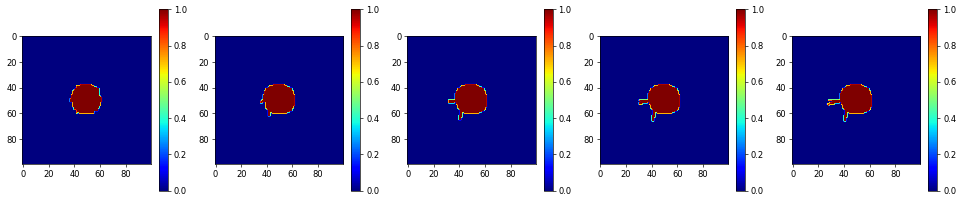

In [64]:
import matlab.engine
import copy
eng = matlab.engine.start_matlab()

rand_case = np.random.randint((len(val_dataset)))
example_x = val_dataset[rand_case,:,:,:,:]
example_theta = val_dataset[rand_case,0,:,:,1]
tmp_p_var = example_theta

plt.figure(figsize=(20, 4), dpi=60)
plt.subplot(1,5,1)
plt.imshow(example_x[0,:,:,0], cmap='jet')
plt.colorbar()
plt.subplot(1,5,2)
plt.imshow(example_x[1,:,:,0], cmap='jet')
plt.colorbar()
plt.subplot(1,5,3)
plt.imshow(example_x[2,:,:,0], cmap='jet')
plt.colorbar()
plt.subplot(1,5,4)
plt.imshow(example_x[3,:,:,0], cmap='jet')
plt.colorbar()
plt.subplot(1,5,5)
plt.imshow(example_x[4,:,:,0], cmap='jet')
plt.colorbar()
plt.show()

x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

for i in range(20):
    new_prediction = model.predict(x_in,verbose="0")
    predicted_frame = np.expand_dims(new_prediction[0,-1, ...], axis=0)
    phi = new_prediction[0,0,:,:,0]
    tips = new_prediction[0,0,:,:,0]
    tub = new_prediction[0,0,:,:,0]
    temps = new_prediction[0,0,:,:,0]
    theta = new_prediction[0,0,:,:,0]

    break
    tips_phi = copy.copy(phi)
    tips_phi[tips_phi!=2]=0
    tips_phi[tips_phi==2]=1
    tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(phi).astype('float64')),5000))

    plt.figure(figsize=(12, 4), dpi=60)
    plt.subplot(1,4,1)
    plt.imshow(phi, cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.imshow(phi, cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,3)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.subplot(1,4,4)
    plt.imshow(example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.show()

    tmp_p_var[phi==2] = 2
    tmp = np.zeros(x_in.shape)
    tmp[0,0,...] = x_in[0,1,...]
    tmp[0,1,...] = x_in[0,2,...]
    tmp[0,2,...] = x_in[0,3,...]
    tmp[0,3,...] = x_in[0,4,...]
    tmp[0,4,:,:,0] = tmp_p_var+tips

    x_in = tmp

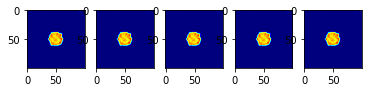

In [67]:
plt.subplot(1,5,1)
plt.imshow(phi, cmap='jet')
plt.subplot(1,5,2)
plt.imshow(tips, cmap='jet')
plt.subplot(1,5,3)
plt.imshow(tub, cmap='jet')
plt.subplot(1,5,4)
plt.imshow(temps, cmap='jet')
plt.subplot(1,5,5)
plt.imshow(theta, cmap='jet')

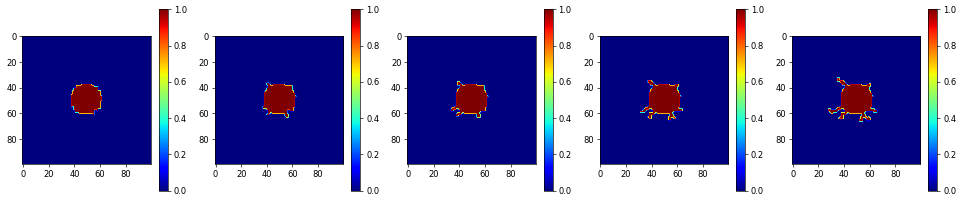

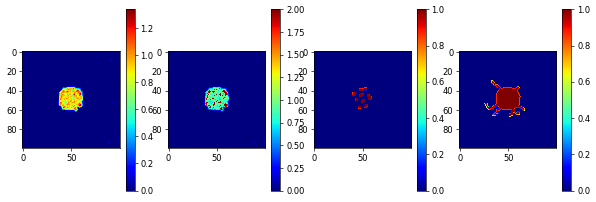

IndexError: index 1 is out of bounds for axis 1 with size 1

In [61]:
# import matlab.engine
# import copy
# eng = matlab.engine.start_matlab()

# rand_case = np.random.randint((len(val_dataset)))
# # example_x = np.expand_dims(val_dataset[rand_case,:,:,:,0], axis=3)
# example_x = val_dataset[rand_case,:,:,:,:]
# example_theta = val_dataset[rand_case,0,:,:,1]
# tmp_p_var = example_theta

# plt.figure(figsize=(20, 4), dpi=60)
# plt.subplot(1,5,1)
# plt.imshow(example_x[0,:,:,0], cmap='jet')
# plt.colorbar()
# plt.subplot(1,5,2)
# plt.imshow(example_x[1,:,:,0], cmap='jet')
# plt.colorbar()
# plt.subplot(1,5,3)
# plt.imshow(example_x[2,:,:,0], cmap='jet')
# plt.colorbar()
# plt.subplot(1,5,4)
# plt.imshow(example_x[3,:,:,0], cmap='jet')
# plt.colorbar()
# plt.subplot(1,5,5)
# plt.imshow(example_x[4,:,:,0], cmap='jet')
# plt.colorbar()
# plt.show()

# x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

# for i in range(20):
#     new_prediction = model.predict(x_in,verbose="0")
#     predicted_frame = np.expand_dims(new_prediction[0,-1, ...], axis=0)
#     p_var = predicted_frame[0,:,:,0]

#     # phi = push(p_var,0.45)
#     phi = copy.copy(p_var)
#     phi[phi>1]=2

#     tips_phi = copy.copy(phi)
#     tips_phi[tips_phi!=2]=0
#     tips_phi[tips_phi==2]=1
#     tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(tips_phi).astype('float64')),5000))

#     plt.figure(figsize=(12, 4), dpi=60)
#     plt.subplot(1,4,1)
#     plt.imshow(p_var, cmap='jet')
#     plt.colorbar()
#     plt.subplot(1,4,2)
#     plt.imshow(phi, cmap='jet')
#     plt.colorbar()
#     plt.subplot(1,4,3)
#     plt.imshow(tips, cmap='jet')
#     plt.colorbar()
#     plt.subplot(1,4,4)
#     plt.imshow(example_x[i+5,:,:,0], cmap='jet')
#     plt.colorbar()
#     plt.show()

#     tmp_p_var[phi==2] = 2
#     tmp = np.zeros(x_in.shape)
#     tmp[0,0,...] = x_in[0,1,...]
#     tmp[0,1,...] = x_in[0,2,...]
#     tmp[0,2,...] = x_in[0,3,...]
#     tmp[0,3,...] = x_in[0,4,...]
#     tmp[0,4,:,:,0] = tmp_p_var+tips

#     x_in = tmp

IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

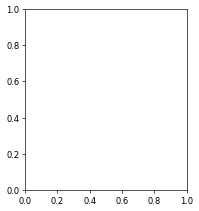

In [25]:
import matlab.engine
eng = matlab.engine.start_matlab()

for i in range(10):

    rand_case = np.random.randint((len(val_dataset)))

    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]

    # plt.figure(figsize=(16, 4), dpi=60)
    # plt.subplot(1,3,1)
    # plt.imshow(example_x[0,:,:,0], cmap='jet')
    # plt.title('Ground truth at frame 0')

    # plt.subplot(1,3,2)
    # plt.imshow(example_x[1,:,:,0], cmap='jet')
    # plt.title('Ground truth at frame 0')

    # plt.subplot(1,3,3)
    # plt.imshow(example_x[2,:,:,0], cmap='jet')
    # plt.title('Ground truth at frame 0')
    # plt.show()

    x_in = np.expand_dims(example_x,axis=0)

    new_prediction = model.predict(x_in,verbose="0")

    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    
    # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,2,:,:,0]).astype('float64')),5000))

    # mre = np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3])))

    plt.figure(figsize=(16, 4), dpi=60)

    plt.subplot(1,4,1)
    plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Prediction at frame %d'%(i+3))

    # plt.subplot(1,4,2)
    # plt.imshow(tips, cmap='jet')
    # plt.colorbar()
    # plt.title('Detected tips at frame %d'%(i+3))

    plt.subplot(1,4,3)
    plt.imshow(example_y[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Ground truth at frame %d'%(i+3))

    plt.subplot(1,4,4)
    plt.imshow(new_prediction[0,0,:,:,0]-example_y[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('Absolute error at frame %d'%(i+3))
    # plt.xlabel('Mean relative error: %f'%mre)

    plt.show()

    # x_in = new_prediction
    # x_in[0,1,:,:,:]

eng.quit()


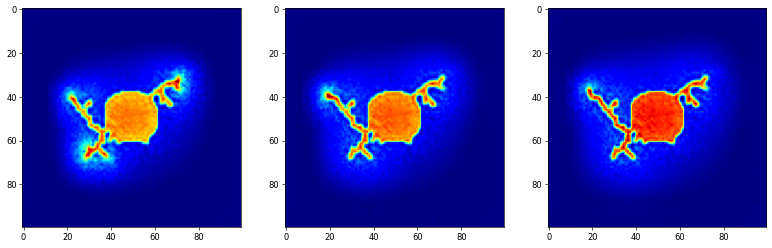

In [ ]:
plt.figure(figsize=(16, 6), dpi=60)
plt.subplot(1,3,1)
plt.imshow(new_prediction[0,0,:,:,0], cmap='jet')
plt.subplot(1,3,2)
plt.imshow(new_prediction[0,1,:,:,0], cmap='jet')
plt.subplot(1,3,3)
plt.imshow(new_prediction[0,2,:,:,0], cmap='jet')

In [ ]:
import matlab.engine
from tqdm import tqdm
eng = matlab.engine.start_matlab()

mre = []
for rand_case in tqdm (range(len(val_dataset)), desc="Running ..."):
    example_x = x_val[rand_case,...]
    example_y = y_val[rand_case,...]
    x_in = np.expand_dims(np.expand_dims(example_x[0,...],axis=0),axis=0)

    for i in range(example_x.shape[0]-3):

        new_prediction = model.predict(x_in, verbose="0")
        temp = np.zeros([1,1,100,100,3])

        # tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(new_prediction[0,0,:,:,0]).astype('float64')),5000))
        temp[0,0,:,:,0] = x_in[0,0,:,:,1]
        temp[0,0,:,:,1] = x_in[0,0,:,:,2]
        temp[0,0,:,:,2] = np.round(new_prediction[0,0,:,:,0])+tips

        x_in = temp

        mre.append(np.sqrt(np.sum(np.square(new_prediction[0,0,:,:,0]-example_y[i,:,:,0])/(new_prediction.shape[2]*new_prediction.shape[3]))))

print(sum(mre) / len(mre))
eng.quit()


Running ...:   0%|          | 0/23 [00:00<?, ?it/s]


NameError: name 'example_tips' is not defined